# Diffusion Policy for the Push-T dataset with visual observations

This is just a port to PyTorch Lightning from the notebook from here: https://colab.research.google.com/drive/18GIHeOQ5DyjMN8iIRZL2EKZ0745NLIpg?usp=sharing#scrollTo=93E9RdnR4D8v

## Imports


In [1]:
# diffusion policy import
from typing import Tuple, Sequence, Dict, Union, Optional, Callable
import numpy as np
import math

import pytorch_lightning as pl
from pytorch_lightning.loggers.wandb import WandbLogger
import wandb

import torch
import torch.nn as nn
import torchvision
import collections
import zarr
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm


# env import
#import gym
#from gym import spaces
#import pygame
#import pymunk
#import pymunk.pygame_util
#from pymunk.space_debug_draw_options import SpaceDebugColor
#from pymunk.vec2d import Vec2d
#import shapely.geometry as sg
#import cv2
#import skimage.transform as st
#from skvideo.io import vwrite
from IPython.display import Video
import gdown
import os
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
torch.cuda.is_available()

True

## Hyperparameters

In [3]:
batch_size = 64
num_epochs = 100
num_workers = 1

## Loading the dataset
Creating the dataloader

Defines `PushTImageDataset` and helper functions.

**The dataset class**:
- Loads data ((image, agent_pos), action) from a zarr storage.
- Normalizes each dimension of agent_pos and action to [-1,1].
- Returns:
  - All possible segments with length `pred_horizon`.
  - Pads the beginning and the end of each episode with repetition.
  - key `image`: shape (obs_hoirzon, 3, 96, 96).
  - key `agent_pos`: shape (obs_hoirzon, 2).
  - key `action`: shape (pred_horizon, 2).

In [4]:
from push_t_dataset.push_t_dataset import PushTImageDataLoader

# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8
#|o|o|                             observations: 2
#| |a|a|a|a|a|a|a|a|               actions executed: 8
#|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

# create dataset from file

# save training data statistics (min, max) for each dim
#stats = dataset.stats

# create dataloader
dataloader = PushTImageDataLoader(
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True
)
# visualize data in batch
batch = next(iter(dataloader))
print("batch['image'].shape:", batch['image'].shape)
print("batch['agent_pos'].shape:", batch['agent_pos'].shape)
print("batch['action'].shape", batch['action'].shape)

numerical_obs_dim = batch['agent_pos'].shape[-1]
action_dim = batch['action'].shape[-1]

batch['image'].shape: torch.Size([64, 2, 3, 96, 96])
batch['agent_pos'].shape: torch.Size([64, 2, 2])
batch['action'].shape torch.Size([64, 16, 2])


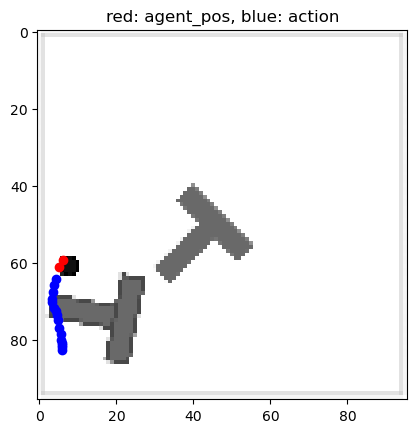

In [5]:
# Visuaize a sample from the dataset
# showing the observed agent poisition and the action on top of the image

import numpy as np
import matplotlib.pyplot as plt


def visualize_sample(sample):
    """
    Visualize a sample from the dataset
    showing the observed agent poisition and the action on top of the image

    Args:
        sample (dict): sample from the dataset. Contains: 
            image (B, T_o, C, H, W), 
            action (B, T_a, 2), 
            agent_pos (B, T_o, 2)
    """
    image = sample['image'][0, 0, 0].numpy()
    #image = sample['image'][0,0].numpy().transpose(1, 2, 0) 
    action = sample['action'][0].numpy()
    agent_pos = sample['agent_pos'][0].numpy()

    # scale the action and agent_pos and shift them to be positive
    action = (action + 1) * 0.5 * image.shape[-1]
    agent_pos = (agent_pos + 1) * 0.5 * image.shape[-1]
    
    # add legend
    plt.title('red: agent_pos, blue: action')

    plt.imshow(image, cmap='gray')
    plt.scatter(agent_pos[:, 0], agent_pos[:, 1], color='red')
    plt.scatter(action[:, 0], action[:, 1], color='blue')
    plt.show()

batch = next(iter(dataloader))
visualize_sample(batch)


## DDPM module
This contains the:
- Visual encoder
- The noise-predictor
    - The sinusoidal temporal encoding


### The DDPMPolicy  module

In [6]:
from ddpm_policy.ddpm_policy import DDPMPolicy

ddpm_policy = DDPMPolicy(
    mask_probability = 0.5,
    pred_horizon = 16,
    obs_horizon = 2,
    action_dim = 2,
    numerical_obs_dim=2,
    dataloader = dataloader,
    num_epochs = num_epochs
)

number of parameters: 7.994727e+07


/workspaces/conditional_diffusion_lightning/push_t_lightning/ddpm_policy/ddpm_policy.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.val_img = torch.tensor(test_sample["image"]).to(self.device)
/workspaces/conditional_diffusion_lightning/push_t_lightning/ddpm_policy/ddpm_policy.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.val_agent_pos = torch.tensor(test_sample["agent_pos"]).to(self.device)


### Show that the model can generate actions before training

100%|██████████| 100/100 [00:00<00:00, 108.27it/s]


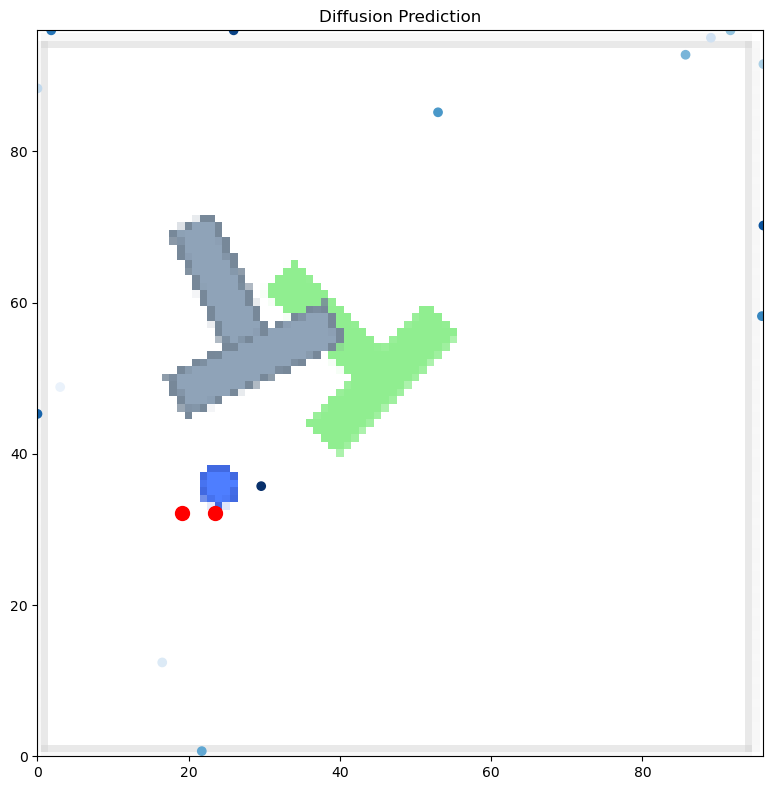

In [7]:
ddpm_policy.cuda()
ddpm_policy.on_train_epoch_end(show_plot=True)
    

## Fit the model to the datset

### Training

In [8]:
wandb_logger = WandbLogger(project='push-t_lightning')
trainer = pl.Trainer(max_epochs=num_epochs, 
                     devices=1,
                     logger=wandb_logger
                    )
trainer.fit(ddpm_policy, dataloader)   

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sigmundhh. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params
------------------------------------------------------
0 | visual_encoder  | VisualEncoder     | 11.2 M
1 | noise_predictor | ConditionalUnet1D | 79.9 M
2 | criterion       | MSELoss           | 0     
------------------------------------------------------
91.1 M    Trainable params
0         Non-trainable params
91.1 M    Total params
364.495   Total estimated model params size (MB)
/opt/

Epoch 0: 100%|██████████| 379/379 [00:32<00:00, 11.53it/s, v_num=hff7, train_loss=1.030]

100%|██████████| 100/100 [00:00<00:00, 107.22it/s]


Epoch 1: 100%|██████████| 379/379 [00:30<00:00, 12.28it/s, v_num=hff7, train_loss=0.676]

100%|██████████| 100/100 [00:00<00:00, 106.34it/s]


Epoch 2: 100%|██████████| 379/379 [00:29<00:00, 12.79it/s, v_num=hff7, train_loss=0.296]

100%|██████████| 100/100 [00:00<00:00, 106.69it/s]


Epoch 3: 100%|██████████| 379/379 [00:31<00:00, 12.10it/s, v_num=hff7, train_loss=0.111]

100%|██████████| 100/100 [00:00<00:00, 106.09it/s]


Epoch 4: 100%|██████████| 379/379 [00:32<00:00, 11.56it/s, v_num=hff7, train_loss=0.142] 

100%|██████████| 100/100 [00:00<00:00, 105.09it/s]


Epoch 5: 100%|██████████| 379/379 [00:29<00:00, 12.84it/s, v_num=hff7, train_loss=0.0951]

100%|██████████| 100/100 [00:00<00:00, 106.92it/s]


Epoch 6: 100%|██████████| 379/379 [00:28<00:00, 13.22it/s, v_num=hff7, train_loss=0.170] 

100%|██████████| 100/100 [00:00<00:00, 106.74it/s]


Epoch 7: 100%|██████████| 379/379 [00:30<00:00, 12.37it/s, v_num=hff7, train_loss=0.105] 

100%|██████████| 100/100 [00:00<00:00, 106.24it/s]


Epoch 8: 100%|██████████| 379/379 [00:30<00:00, 12.38it/s, v_num=hff7, train_loss=0.0998]

100%|██████████| 100/100 [00:00<00:00, 106.86it/s]


Epoch 9: 100%|██████████| 379/379 [00:32<00:00, 11.58it/s, v_num=hff7, train_loss=0.0583]

100%|██████████| 100/100 [00:00<00:00, 107.46it/s]


Epoch 10: 100%|██████████| 379/379 [00:32<00:00, 11.50it/s, v_num=hff7, train_loss=0.061] 

100%|██████████| 100/100 [00:00<00:00, 107.03it/s]


Epoch 11: 100%|██████████| 379/379 [00:30<00:00, 12.33it/s, v_num=hff7, train_loss=0.0784]

100%|██████████| 100/100 [00:00<00:00, 106.11it/s]


Epoch 12: 100%|██████████| 379/379 [00:28<00:00, 13.30it/s, v_num=hff7, train_loss=0.0486]

100%|██████████| 100/100 [00:00<00:00, 106.56it/s]


Epoch 13: 100%|██████████| 379/379 [00:29<00:00, 12.97it/s, v_num=hff7, train_loss=0.0589]

100%|██████████| 100/100 [00:00<00:00, 105.83it/s]


Epoch 14: 100%|██████████| 379/379 [00:31<00:00, 11.90it/s, v_num=hff7, train_loss=0.0547]

100%|██████████| 100/100 [00:00<00:00, 106.54it/s]


Epoch 15: 100%|██████████| 379/379 [00:29<00:00, 12.85it/s, v_num=hff7, train_loss=0.0452]

100%|██████████| 100/100 [00:00<00:00, 106.38it/s]


Epoch 16: 100%|██████████| 379/379 [00:28<00:00, 13.23it/s, v_num=hff7, train_loss=0.0614]

100%|██████████| 100/100 [00:00<00:00, 106.50it/s]


Epoch 17: 100%|██████████| 379/379 [00:28<00:00, 13.25it/s, v_num=hff7, train_loss=0.0664]

100%|██████████| 100/100 [00:00<00:00, 106.57it/s]


Epoch 18: 100%|██████████| 379/379 [00:28<00:00, 13.09it/s, v_num=hff7, train_loss=0.0368]

100%|██████████| 100/100 [00:00<00:00, 106.01it/s]


Epoch 19: 100%|██████████| 379/379 [00:28<00:00, 13.13it/s, v_num=hff7, train_loss=0.0329]

100%|██████████| 100/100 [00:00<00:00, 106.51it/s]


Epoch 20: 100%|██████████| 379/379 [00:28<00:00, 13.18it/s, v_num=hff7, train_loss=0.0255]

100%|██████████| 100/100 [00:00<00:00, 106.32it/s]


Epoch 21: 100%|██████████| 379/379 [00:28<00:00, 13.53it/s, v_num=hff7, train_loss=0.0442]

100%|██████████| 100/100 [00:00<00:00, 106.15it/s]


Epoch 22: 100%|██████████| 379/379 [00:30<00:00, 12.45it/s, v_num=hff7, train_loss=0.0293]

100%|██████████| 100/100 [00:00<00:00, 105.60it/s]


Epoch 23: 100%|██████████| 379/379 [00:29<00:00, 12.79it/s, v_num=hff7, train_loss=0.0288]

100%|██████████| 100/100 [00:00<00:00, 106.38it/s]


Epoch 24: 100%|██████████| 379/379 [00:31<00:00, 11.91it/s, v_num=hff7, train_loss=0.053] 

100%|██████████| 100/100 [00:00<00:00, 106.07it/s]


Epoch 25: 100%|██████████| 379/379 [00:28<00:00, 13.50it/s, v_num=hff7, train_loss=0.0602]

100%|██████████| 100/100 [00:00<00:00, 107.05it/s]


Epoch 26: 100%|██████████| 379/379 [00:30<00:00, 12.26it/s, v_num=hff7, train_loss=0.0709]

100%|██████████| 100/100 [00:00<00:00, 106.49it/s]


Epoch 27: 100%|██████████| 379/379 [00:32<00:00, 11.63it/s, v_num=hff7, train_loss=0.0624]

100%|██████████| 100/100 [00:00<00:00, 106.30it/s]


Epoch 28: 100%|██████████| 379/379 [00:32<00:00, 11.66it/s, v_num=hff7, train_loss=0.0744]

100%|██████████| 100/100 [00:00<00:00, 106.67it/s]


Epoch 29: 100%|██████████| 379/379 [00:32<00:00, 11.67it/s, v_num=hff7, train_loss=0.115] 

100%|██████████| 100/100 [00:00<00:00, 105.71it/s]


Epoch 30: 100%|██████████| 379/379 [00:32<00:00, 11.67it/s, v_num=hff7, train_loss=0.0359]

100%|██████████| 100/100 [00:00<00:00, 106.05it/s]


Epoch 31: 100%|██████████| 379/379 [00:32<00:00, 11.63it/s, v_num=hff7, train_loss=0.0443]

100%|██████████| 100/100 [00:00<00:00, 105.96it/s]


Epoch 32: 100%|██████████| 379/379 [00:33<00:00, 11.47it/s, v_num=hff7, train_loss=0.031] 

100%|██████████| 100/100 [00:00<00:00, 106.32it/s]


Epoch 33: 100%|██████████| 379/379 [00:32<00:00, 11.61it/s, v_num=hff7, train_loss=0.0383]

100%|██████████| 100/100 [00:00<00:00, 106.78it/s]


Epoch 34: 100%|██████████| 379/379 [00:32<00:00, 11.60it/s, v_num=hff7, train_loss=0.0647]

100%|██████████| 100/100 [00:00<00:00, 105.27it/s]


Epoch 35: 100%|██████████| 379/379 [00:32<00:00, 11.64it/s, v_num=hff7, train_loss=0.0511]

100%|██████████| 100/100 [00:00<00:00, 105.99it/s]


Epoch 36: 100%|██████████| 379/379 [00:32<00:00, 11.49it/s, v_num=hff7, train_loss=0.0132]

100%|██████████| 100/100 [00:00<00:00, 105.37it/s]


Epoch 37: 100%|██████████| 379/379 [00:32<00:00, 11.64it/s, v_num=hff7, train_loss=0.0298]

100%|██████████| 100/100 [00:00<00:00, 105.90it/s]


Epoch 38: 100%|██████████| 379/379 [00:32<00:00, 11.63it/s, v_num=hff7, train_loss=0.0684]

100%|██████████| 100/100 [00:00<00:00, 106.15it/s]


Epoch 39: 100%|██████████| 379/379 [00:32<00:00, 11.58it/s, v_num=hff7, train_loss=0.0199]

100%|██████████| 100/100 [00:00<00:00, 106.31it/s]


Epoch 40: 100%|██████████| 379/379 [00:32<00:00, 11.72it/s, v_num=hff7, train_loss=0.0289]

100%|██████████| 100/100 [00:00<00:00, 106.54it/s]


Epoch 41: 100%|██████████| 379/379 [00:30<00:00, 12.29it/s, v_num=hff7, train_loss=0.038] 

100%|██████████| 100/100 [00:00<00:00, 106.35it/s]


Epoch 42: 100%|██████████| 379/379 [00:30<00:00, 12.52it/s, v_num=hff7, train_loss=0.060] 

100%|██████████| 100/100 [00:00<00:00, 106.41it/s]


Epoch 43: 100%|██████████| 379/379 [00:32<00:00, 11.70it/s, v_num=hff7, train_loss=0.0517]

100%|██████████| 100/100 [00:00<00:00, 106.05it/s]


Epoch 44: 100%|██████████| 379/379 [00:31<00:00, 11.87it/s, v_num=hff7, train_loss=0.0206]

100%|██████████| 100/100 [00:00<00:00, 106.61it/s]


Epoch 45: 100%|██████████| 379/379 [00:31<00:00, 11.96it/s, v_num=hff7, train_loss=0.0162]

100%|██████████| 100/100 [00:00<00:00, 106.17it/s]


Epoch 46: 100%|██████████| 379/379 [00:31<00:00, 12.22it/s, v_num=hff7, train_loss=0.00988]

100%|██████████| 100/100 [00:00<00:00, 106.72it/s]


Epoch 47: 100%|██████████| 379/379 [00:32<00:00, 11.60it/s, v_num=hff7, train_loss=0.0254] 

100%|██████████| 100/100 [00:00<00:00, 105.63it/s]


Epoch 48: 100%|██████████| 379/379 [00:31<00:00, 11.94it/s, v_num=hff7, train_loss=0.028] 

100%|██████████| 100/100 [00:00<00:00, 106.68it/s]


Epoch 49: 100%|██████████| 379/379 [00:31<00:00, 11.91it/s, v_num=hff7, train_loss=0.0447]

100%|██████████| 100/100 [00:00<00:00, 105.60it/s]


Epoch 50: 100%|██████████| 379/379 [00:31<00:00, 11.92it/s, v_num=hff7, train_loss=0.0679]

100%|██████████| 100/100 [00:00<00:00, 106.07it/s]


Epoch 51: 100%|██████████| 379/379 [00:31<00:00, 12.05it/s, v_num=hff7, train_loss=0.0403]

100%|██████████| 100/100 [00:00<00:00, 105.65it/s]


Epoch 52: 100%|██████████| 379/379 [00:30<00:00, 12.32it/s, v_num=hff7, train_loss=0.0234]

100%|██████████| 100/100 [00:00<00:00, 106.35it/s]


Epoch 53: 100%|██████████| 379/379 [00:32<00:00, 11.74it/s, v_num=hff7, train_loss=0.0509]

100%|██████████| 100/100 [00:00<00:00, 105.68it/s]


Epoch 54: 100%|██████████| 379/379 [00:32<00:00, 11.75it/s, v_num=hff7, train_loss=0.0271]

100%|██████████| 100/100 [00:00<00:00, 107.13it/s]


Epoch 55: 100%|██████████| 379/379 [00:32<00:00, 11.71it/s, v_num=hff7, train_loss=0.039] 

100%|██████████| 100/100 [00:00<00:00, 106.30it/s]


Epoch 56: 100%|██████████| 379/379 [00:31<00:00, 12.03it/s, v_num=hff7, train_loss=0.0126]

100%|██████████| 100/100 [00:00<00:00, 106.80it/s]


Epoch 57: 100%|██████████| 379/379 [00:32<00:00, 11.83it/s, v_num=hff7, train_loss=0.019] 

100%|██████████| 100/100 [00:00<00:00, 105.66it/s]


Epoch 58: 100%|██████████| 379/379 [00:32<00:00, 11.73it/s, v_num=hff7, train_loss=0.0341]

100%|██████████| 100/100 [00:00<00:00, 107.07it/s]


Epoch 59: 100%|██████████| 379/379 [00:32<00:00, 11.70it/s, v_num=hff7, train_loss=0.026] 

100%|██████████| 100/100 [00:00<00:00, 106.47it/s]


Epoch 60: 100%|██████████| 379/379 [00:32<00:00, 11.68it/s, v_num=hff7, train_loss=0.0259]

100%|██████████| 100/100 [00:00<00:00, 106.73it/s]


Epoch 61: 100%|██████████| 379/379 [00:31<00:00, 11.99it/s, v_num=hff7, train_loss=0.013] 

100%|██████████| 100/100 [00:00<00:00, 106.33it/s]


Epoch 62: 100%|██████████| 379/379 [00:32<00:00, 11.82it/s, v_num=hff7, train_loss=0.0475]

100%|██████████| 100/100 [00:00<00:00, 106.24it/s]


Epoch 63: 100%|██████████| 379/379 [00:32<00:00, 11.83it/s, v_num=hff7, train_loss=0.0285]

100%|██████████| 100/100 [00:00<00:00, 106.89it/s]


Epoch 64: 100%|██████████| 379/379 [00:32<00:00, 11.71it/s, v_num=hff7, train_loss=0.0228]

100%|██████████| 100/100 [00:00<00:00, 106.02it/s]


Epoch 65: 100%|██████████| 379/379 [00:32<00:00, 11.80it/s, v_num=hff7, train_loss=0.0306]

100%|██████████| 100/100 [00:00<00:00, 106.49it/s]


Epoch 66: 100%|██████████| 379/379 [00:32<00:00, 11.64it/s, v_num=hff7, train_loss=0.0747]

100%|██████████| 100/100 [00:00<00:00, 106.11it/s]


Epoch 67: 100%|██████████| 379/379 [00:32<00:00, 11.66it/s, v_num=hff7, train_loss=0.0672]

100%|██████████| 100/100 [00:00<00:00, 106.69it/s]


Epoch 68: 100%|██████████| 379/379 [00:32<00:00, 11.62it/s, v_num=hff7, train_loss=0.017] 

100%|██████████| 100/100 [00:00<00:00, 106.77it/s]


Epoch 69: 100%|██████████| 379/379 [00:32<00:00, 11.65it/s, v_num=hff7, train_loss=0.0565]

100%|██████████| 100/100 [00:00<00:00, 106.43it/s]


Epoch 70: 100%|██████████| 379/379 [00:32<00:00, 11.78it/s, v_num=hff7, train_loss=0.0572]

100%|██████████| 100/100 [00:00<00:00, 106.25it/s]


Epoch 71: 100%|██████████| 379/379 [00:30<00:00, 12.63it/s, v_num=hff7, train_loss=0.0366]

100%|██████████| 100/100 [00:00<00:00, 105.80it/s]


Epoch 72: 100%|██████████| 379/379 [00:29<00:00, 12.84it/s, v_num=hff7, train_loss=0.0536]

100%|██████████| 100/100 [00:00<00:00, 105.92it/s]


Epoch 73: 100%|██████████| 379/379 [00:32<00:00, 11.72it/s, v_num=hff7, train_loss=0.0736]

100%|██████████| 100/100 [00:00<00:00, 105.85it/s]


Epoch 74: 100%|██████████| 379/379 [00:32<00:00, 11.65it/s, v_num=hff7, train_loss=0.0141]

100%|██████████| 100/100 [00:00<00:00, 105.62it/s]


Epoch 75: 100%|██████████| 379/379 [00:32<00:00, 11.65it/s, v_num=hff7, train_loss=0.0303]

100%|██████████| 100/100 [00:00<00:00, 106.32it/s]


Epoch 76: 100%|██████████| 379/379 [00:28<00:00, 13.53it/s, v_num=hff7, train_loss=0.0353] 

100%|██████████| 100/100 [00:00<00:00, 106.65it/s]


Epoch 77: 100%|██████████| 379/379 [00:30<00:00, 12.33it/s, v_num=hff7, train_loss=0.0109]

100%|██████████| 100/100 [00:00<00:00, 105.97it/s]


Epoch 78: 100%|██████████| 379/379 [00:32<00:00, 11.69it/s, v_num=hff7, train_loss=0.0151]

100%|██████████| 100/100 [00:00<00:00, 105.89it/s]


Epoch 79: 100%|██████████| 379/379 [00:29<00:00, 12.77it/s, v_num=hff7, train_loss=0.0289]

100%|██████████| 100/100 [00:00<00:00, 105.92it/s]


Epoch 80: 100%|██████████| 379/379 [00:32<00:00, 11.62it/s, v_num=hff7, train_loss=0.0436] 

100%|██████████| 100/100 [00:00<00:00, 105.54it/s]


Epoch 81: 100%|██████████| 379/379 [00:32<00:00, 11.81it/s, v_num=hff7, train_loss=0.0643]

100%|██████████| 100/100 [00:00<00:00, 106.07it/s]


Epoch 82: 100%|██████████| 379/379 [00:32<00:00, 11.55it/s, v_num=hff7, train_loss=0.0268]

100%|██████████| 100/100 [00:00<00:00, 106.39it/s]


Epoch 83: 100%|██████████| 379/379 [00:32<00:00, 11.65it/s, v_num=hff7, train_loss=0.0431] 

100%|██████████| 100/100 [00:00<00:00, 107.06it/s]


Epoch 84: 100%|██████████| 379/379 [00:31<00:00, 12.02it/s, v_num=hff7, train_loss=0.041] 

100%|██████████| 100/100 [00:00<00:00, 106.34it/s]


Epoch 85: 100%|██████████| 379/379 [00:31<00:00, 12.17it/s, v_num=hff7, train_loss=0.0102] 

100%|██████████| 100/100 [00:00<00:00, 106.60it/s]


Epoch 86: 100%|██████████| 379/379 [00:32<00:00, 11.58it/s, v_num=hff7, train_loss=0.0318]

100%|██████████| 100/100 [00:00<00:00, 106.49it/s]


Epoch 87: 100%|██████████| 379/379 [00:31<00:00, 11.87it/s, v_num=hff7, train_loss=0.00984]

100%|██████████| 100/100 [00:00<00:00, 106.24it/s]


Epoch 88: 100%|██████████| 379/379 [00:30<00:00, 12.31it/s, v_num=hff7, train_loss=0.0558] 

100%|██████████| 100/100 [00:00<00:00, 107.01it/s]


Epoch 89: 100%|██████████| 379/379 [00:32<00:00, 11.68it/s, v_num=hff7, train_loss=0.0543] 

100%|██████████| 100/100 [00:00<00:00, 106.43it/s]


Epoch 90: 100%|██████████| 379/379 [00:32<00:00, 11.60it/s, v_num=hff7, train_loss=0.0154] 

100%|██████████| 100/100 [00:00<00:00, 106.49it/s]


Epoch 91: 100%|██████████| 379/379 [00:32<00:00, 11.60it/s, v_num=hff7, train_loss=0.0237] 

100%|██████████| 100/100 [00:00<00:00, 106.72it/s]


Epoch 92: 100%|██████████| 379/379 [00:32<00:00, 11.59it/s, v_num=hff7, train_loss=0.0385] 

100%|██████████| 100/100 [00:00<00:00, 106.30it/s]


Epoch 93: 100%|██████████| 379/379 [00:30<00:00, 12.38it/s, v_num=hff7, train_loss=0.0215] 

100%|██████████| 100/100 [00:00<00:00, 106.63it/s]


Epoch 94: 100%|██████████| 379/379 [00:32<00:00, 11.62it/s, v_num=hff7, train_loss=0.0179]

100%|██████████| 100/100 [00:00<00:00, 106.40it/s]


Epoch 95: 100%|██████████| 379/379 [00:28<00:00, 13.27it/s, v_num=hff7, train_loss=0.0272] 

100%|██████████| 100/100 [00:00<00:00, 106.03it/s]


Epoch 96: 100%|██████████| 379/379 [00:28<00:00, 13.42it/s, v_num=hff7, train_loss=0.0239] 

100%|██████████| 100/100 [00:00<00:00, 106.94it/s]


Epoch 97: 100%|██████████| 379/379 [00:28<00:00, 13.07it/s, v_num=hff7, train_loss=0.0275] 

100%|██████████| 100/100 [00:00<00:00, 106.72it/s]


Epoch 98: 100%|██████████| 379/379 [00:28<00:00, 13.44it/s, v_num=hff7, train_loss=0.00778]

100%|██████████| 100/100 [00:00<00:00, 106.71it/s]


Epoch 99: 100%|██████████| 379/379 [00:32<00:00, 11.68it/s, v_num=hff7, train_loss=0.0326] 

100%|██████████| 100/100 [00:00<00:00, 106.18it/s]
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 379/379 [00:35<00:00, 10.71it/s, v_num=hff7, train_loss=0.0326]


In [9]:
# save the model
torch.save(ddpm_policy.state_dict(), 'models/push_t_lightning_adamw_cosinelr_ema_100steps_gm.pt')
print("Model saved as models/push_t_lightning_adamw_cosinelr_ema_100steps_gm.pt")

Model saved as models/push_t_lightning_adamw_cosinelr_ema_100steps_gm.pt


#### Visualize an action prediction

100%|██████████| 100/100 [00:00<00:00, 106.75it/s]


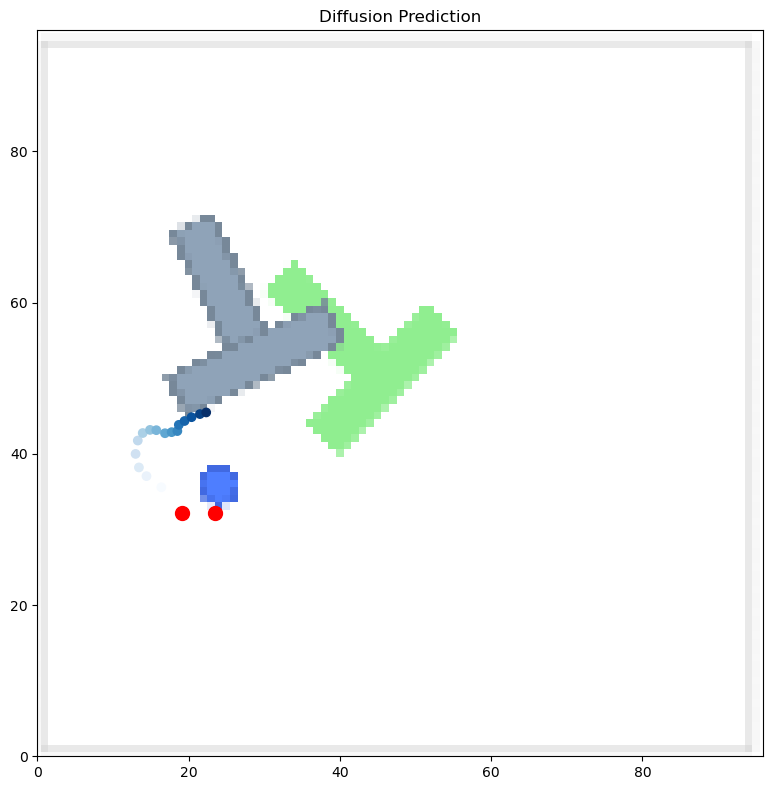

In [10]:
# load model
#checkpoint = torch.load('models/push_t_lightning_adamw_cosinelr_ema_100steps_gm.pt')
#ddpm_policy.load_state_dict(checkpoint)

ddpm_policy.cuda()
ddpm_policy.on_train_epoch_end(show_plot=True)

## Environment definition

In [11]:
from push_t_env.push_t_env import PushTImageEnv

#@markdown ### **Env Demo**
#@markdown Standard Gym Env (0.21.0 API)

# 0. create env object
env = PushTImageEnv()

# 1. seed env for initial state.
# Seed 0-200 are used for the demonstration dataset.
env.seed(1000)

# 2. must reset before use
obs = env.reset()

# 3. 2D positional action space [0,512]
action = env.action_space.sample()

# 4. Standard gym step method
obs, reward, done, info = env.step(action)

# prints and explains each dimension of the observation and action vectors
with np.printoptions(precision=4, suppress=True, threshold=5):
    print("obs['image'].shape:", obs['image'].shape, "float32, [0,1]")
    print("obs['agent_pos'].shape:", obs['agent_pos'].shape, "float32, [0,512]")
    print("action.shape: ", action.shape, "float32, [0,512]")

pygame 2.1.2 (SDL 2.0.16, Python 3.10.8)
Hello from the pygame community. https://www.pygame.org/contribute.html
obs['image'].shape: (3, 96, 96) float32, [0,1]
obs['agent_pos'].shape: (2,) float32, [0,512]
action.shape:  (2,) float32, [0,512]


## Visualizing the performance

In [12]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from push_t_dataset.push_t_dataset import normalize_data, unnormalize_data

100%|██████████| 100/100 [00:00<00:00, 144.94it/s]8<00:00, 10.94it/s, reward=0.671]
Eval PushTImageEnv: 201it [00:18, 10.62it/s, reward=0.671]                         


Score:  0.6707787160727674


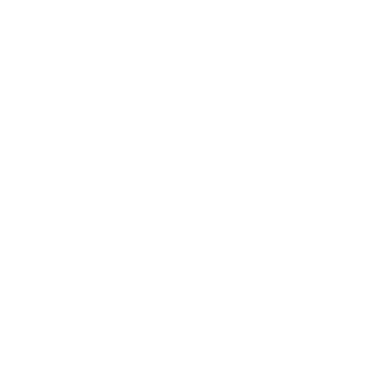

In [13]:
# limit enviornment interaction to 200 steps before termination
max_steps = 200
env = PushTImageEnv()
# use a seed >200 to avoid initial states seen in the training dataset
env.seed(100000)

# get first observation
obs = env.reset()

# keep a queue of last 2 steps of observations
obs_deque = collections.deque(
    [obs] * obs_horizon, maxlen=obs_horizon)
# save visualization and rewards
imgs = [env.render(mode='rgb_array')]
rewards = list()
done = False
step_idx = 0
stats = dataloader.dataset.stats

with tqdm(total=max_steps, desc="Eval PushTImageEnv") as pbar:
    while not done:
        B = 1
        # stack the last obs_horizon number of observations
        images = np.stack([x['image'] for x in obs_deque])
        agent_poses = np.stack([x['agent_pos'] for x in obs_deque])

        # normalize observation
        nagent_poses = normalize_data(agent_poses, stats=stats['agent_pos'])
        # images are already normalized to [0,1]
        nimages = images

        # device transfer
        nimages = torch.from_numpy(nimages).to(ddpm_policy.device, dtype=torch.float32).unsqueeze(0)
        # (obs_horizon,3,96,96)
        nagent_poses = torch.from_numpy(nagent_poses).to(ddpm_policy.device, dtype=torch.float32).unsqueeze(0)
        # (obs_horizon, numerical_obs_dim)

        #print(nimages.shape, nagent_poses.shape)

        naction = ddpm_policy.generate_actions(nimages, nagent_poses, eval=True) # (B, pred_horizon, action_dim)

        # unnormalize action
        naction = naction.detach().to('cpu').numpy()
        # (B, pred_horizon, action_dim)
        naction = naction[0]
        action_pred = unnormalize_data(naction, stats=stats['action'])

        # only take action_horizon number of actions
        start = obs_horizon - 1
        end = start + action_horizon
        #action = action_pred[start:end,:]
        action = action_pred[:action_horizon,:]
        # (action_horizon, action_dim)

        # execute action_horizon number of steps
        # without replanning
        for i in range(len(action)):
            # stepping env
            obs, reward, done, info = env.step(action[i])
            # save observations
            obs_deque.append(obs)
            # and reward/vis
            rewards.append(reward)
            imgs.append(env.render(mode='rgb_array'))

            # update progress bar
            step_idx += 1
            pbar.update(1)
            pbar.set_postfix(reward=reward)
            if step_idx > max_steps:
                done = True
            if done:
                break

# print out the maximum target coverage
print('Score: ', max(rewards))

# Plot the images as an animation
fig = plt.figure()
plt.axis("off")
ims = [[plt.imshow(img, animated=True)] for img in imgs]
ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
HTML(ani.to_jshtml())


import cv2

# save video
video_name = 'push_t_lightning_adamw_cosinelr_ema_100steps.mp4'
height, width, layers = imgs[0].shape
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_name, fourcc, 30, (width,height))
for img in imgs:
    video.write(img)
cv2.destroyAllWindows()
video.release()


In [14]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,99
train_loss,0.03262
trainer/global_step,37899
